# Evaluate the FS algo

Take a time window of prices and decide if SELL, HOLD, BUY, untill the next transaction time.
Iterate through whole history of one stock

In [27]:
using EO, Plots, Lasso, CSV, DataFrames, FileIO

In [28]:
function generate_predictions(x_max, price, training_width, prediction_width, timestep, expert_cnt)

    ps = Vector{Vector{Vector{Float64}}}()

    training_i = 2:training_width+1
    while training_i[end] + prediction_width < x_max
        x = float.(collect(training_i))                                         # training set
        xt = float.(collect(training_i[1]:(training_i[end]+prediction_width)))  # testing set

        # define training
        variables   = [x]
        operations  = Vector{Function}([+, -, *, EO.protected_div, sin, EO.square, EO.cube, EO.logaritmus])
        arities     = [2,2,2,2,1,1,1,1]
        exprs       = Vector{Any}([:x])
        
        # train expert models
        predictions = Vector{Vector{Float64}}()
        while length(predictions) < expert_cnt
            print("\rtraining expert $(length(predictions)+1)")
            try         # optimization can diverge
                # train a model
                best_model, models_hist = EO.feature_synthesis(float.(price[training_i]), variables, operations, arities, exprs, 100, q=10, μ=3, max_depth=5);
                # extract feature for x
                features    = EO.extract_features(models_hist, xt)
                # predict with the best model on the extracted features
                maximal_value = maximum(float.(price[training_i]))+abs(maximum(float.(price[training_i]))-minimum(float.(price[training_i])))
                minimal_value = minimum(float.(price[training_i]))-abs(maximum(float.(price[training_i]))-minimum(float.(price[training_i])))
                prediction  = EO.denoise(EO.prediction(best_model, xt, features; λ=maximal_value, α=minimal_value))
                push!(predictions, prediction)
            catch
                continue
            end
        end

        # evaluate the predictions
        push!(ps, predictions)

        #training_i .+= timestep
        training_i = (training_i[1]+timestep):(training_i[end]+timestep)
    end
    return ps
end

generate_predictions (generic function with 1 method)

2510-element Vector{Vector{Vector{Float64}}}:
 [[1.3637557276817218, 1.2144497687283635, 1.7366083388745819, 1.1377818229891978, 1.6759273776719916, 1.2788125104038361, 1.1317566346265573, 1.3126421650537459, 1.9089376064671266, 1.1943534559200533  …  7.594800173552387, 5.441153044580743, 10.882992464140381, 8.79980102267829, 5.974246555296584, 5.497490772900851, 7.968448738426728, 5.386891870422065, 9.387834585529857, 8.982433945514876], [1.3797016825800765, 1.7131560603706022, 1.2395873430502138, 1.3860275078767201, 1.4733780567297563, 1.8563774295944624, 1.7402582124457588, 1.3327161867407324, 1.7111727275532231, 1.391268820574788  …  4.335717117481319, 4.712414212033281, 3.85757454273125, 4.557292892007644, 3.957422310631, 4.392761417413593, 4.371625212481864, 4.199431845653693, 4.085928625309631, 3.060286466092162], [1.592719467659814, 1.461604676148029, 1.5423976659535141, 1.5519041780696412, 2.1573803372892613, 1.6245366622484418, 1.6849004283215805, 1.9465823439713466, 1.545377

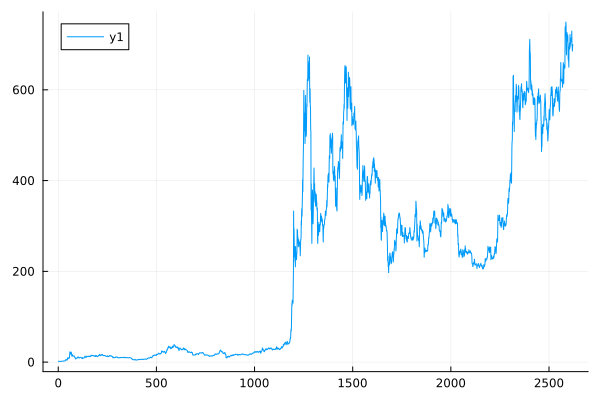

In [29]:
# load stock with predictions

strategy = "tree_GP"
strategy = "LS"
strategy = "FS"

names = ["BNB", "Ethereum", "Polkadot", "Solana", "Fuji Electric ADR", "Metal Component Engineering Ltd", "Perdoceo Education", "American Airlines", "3M", "Apple", "Coca-Cola", "Exxon Mobil", "Ford Motor", "Intel", "Microsoft", "NVIDIA", "Pfizer", "K", "EA"]
name = names[9]
if strategy == "tree_GP"
    res, price = load(joinpath(@__DIR__, "evaluations", "tree_GP", name, "predictions.jld2"))["res"];
elseif  strategy == "LS"
    res, price = load(joinpath(@__DIR__, "evaluations", "LS", name, "predictions.jld2"))["res"];
elseif  strategy == "FS"
    res, price = load(joinpath(@__DIR__, "evaluations", name, "predictions.jld2"))["res"];
end


training_width = 100
prediction_width = 10
timestep = 10
plot(price)

# Graphation

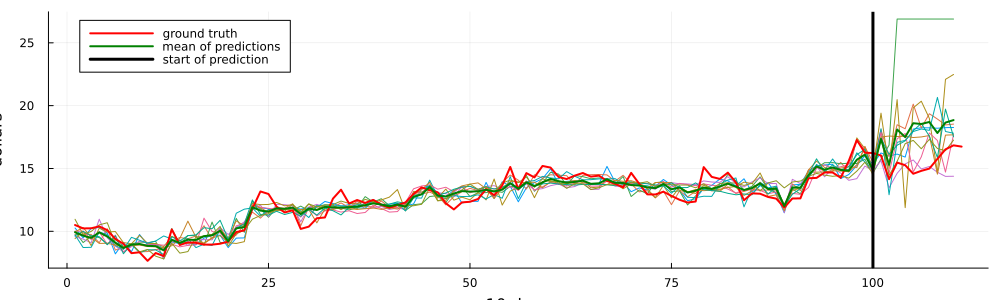

In [30]:
i = 112
p = plot(res[i], label=false, size=(1000,300))
plot!(p, price[(2+timestep*(i-1)):(2+prediction_width+training_width+timestep*(i-1))], linewidth=2, color=:red, label="ground truth")
plot!(p, mean(res[i]), linewidth=2, color=:green, label="mean of predictions")
plot!(p, [training_width], seriestype=:vline, linewidth=3, color=:black, label="start of prediction", ylabel="dollars", xlabel="10 days")
#savefig(p, "../images/LS_pred.svg")

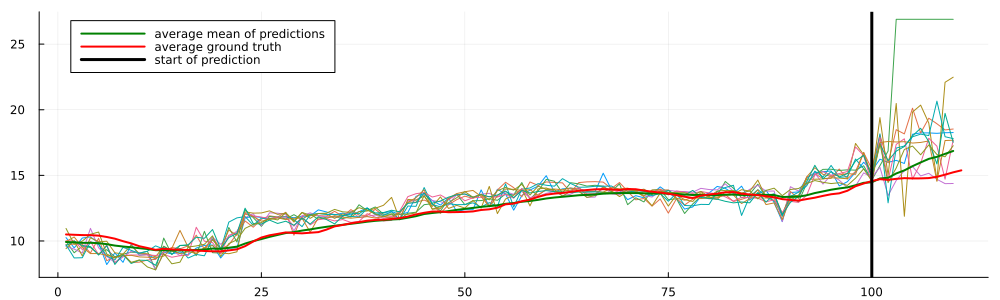

In [31]:
#i = 112
p = plot(res[i], label=false, size=(1000,300))
plot!(p, EO.signal_mean(mean(res[i])), linewidth=2, color=:green, label="average mean of predictions")
plot!(p, EO.signal_mean(float.(price[(2+timestep*(i-1)):(2+prediction_width+training_width+timestep*(i-1))])), linewidth=2, color=:red, label="average ground truth")
plot!(p, [training_width], seriestype=:vline, linewidth=3, color=:black, label="start of prediction")

# Evaluation


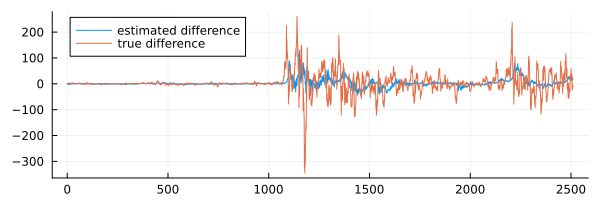

In [32]:
diffs = Vector{Float64}()
true_diffs = Vector{Float64}()

i = 1
for prediction in res
    pr = EO.signal_mean(mean(prediction))
    last_known_val = pr[training_width]
    predicted_val  = pr[training_width+prediction_width]

    diff        = #= 10* =#(predicted_val - last_known_val)
    true_diff   = price[(2+prediction_width+training_width+timestep*(i-1))] - price[(2+training_width+timestep*(i-1))]

    push!(diffs, diff)
    push!(true_diffs, true_diff)
    i+=1
end

p = plot(diffs, label="estimated difference"#= , layout=(2,1) =#, size=(600, 200))
plot!(p, true_diffs, label="true difference")
#plot!(p, abs.(true_diffs.-diffs), label="error", subplot=2)
#savefig(p, "../images/difference_estimation_noisy.svg")
p

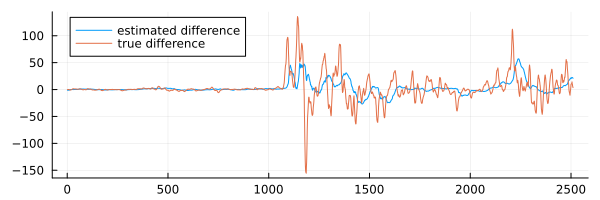

In [33]:

p = plot(EO.signal_mean(diffs), label="estimated difference"#= , layout=(2,1) =#, size=(600, 200))
plot!(p, EO.signal_mean(true_diffs), label="true difference")
#plot!(p, abs.(EO.signal_mean(true_diffs).-EO.signal_mean(diffs)), label="error", subplot=2)
#savefig(p, "../images/difference_estimation.svg")
p

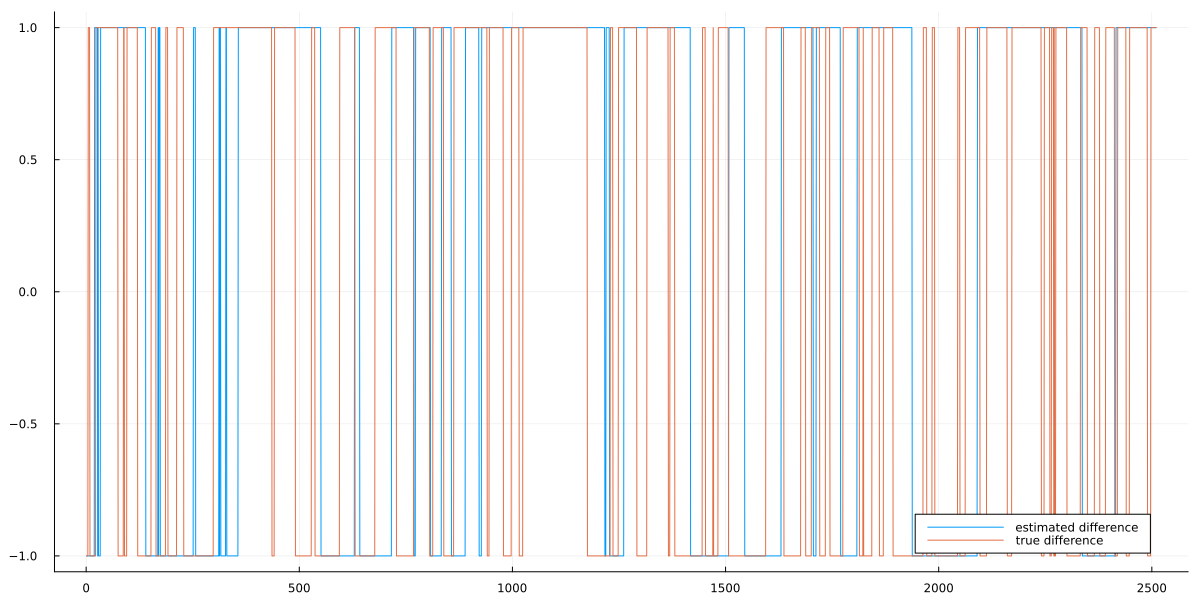

In [34]:
p = plot(sign.(EO.signal_mean(diffs)), label="estimated difference"#= , layout=(2,1) =#, size=(1200, 600))
plot!(p, sign.(EO.signal_mean(true_diffs)), label="true difference")

# Simulation

In [119]:
diffs = Vector{Float64}()

balance = 1 # unit is money
stock_balance = 0
volatility = 0.3          # speed of fund moving, 1 means all cash moves from one asset to the other instantly
required_certainty = 1
λ = 0.1

snapshots_s = Vector{Float64}()
snapshots_m = Vector{Float64}()
stock_value = Vector{Float64}()
stock_value_decim = Vector{Float64}()
actions = Vector{Float64}()
buy  = zeros(length(res))
sell = zeros(length(res))
hold = zeros(length(res))

smoothed_price = EO.signal_mean(float.(price))

prev_diff = nothing

i = 1
for prediction in res
    push!(snapshots_m, balance)
    push!(snapshots_s, stock_balance)

    #update balance
    #previous_price = #= smoothed_ =#price[(2+timestep*(i-1))]
    previous_price = #= smoothed_ =#price[(2+training_width+timestep*(i-1))]
    current_price = #= smoothed_ =#price[(2+prediction_width+training_width+timestep*(i-1))]

    change = current_price/previous_price
    push!(stock_value, stock_balance*current_price)
    push!(stock_value_decim, current_price)

    pr = EO.signal_mean(mean(prediction))
    last_known_val = pr[training_width]
    predicted_val  = pr[training_width+prediction_width]

    diff = #= 10* =#(predicted_val - last_known_val)
    fell = false
    diff = current_price - previous_price
    if isnothing(prev_diff)
        prev_diff = diff
    else
        diff = (1-λ)*prev_diff + λ*diff
        fell = diff < prev_diff
        prev_diff = diff
    end
    push!(diffs, diff)
    if abs(diff) > required_certainty
        if diff < 0         # the value will go down
        #if rand() < 0.5
            #sell
            trade_amount = stock_balance*volatility
            stock_balance = stock_balance - trade_amount

            balance = balance + trade_amount*current_price

            push!(actions, -1)
            sell[i] = 1
        elseif diff > 0
            #buy0.1
            trade_amount = balance*volatility
            balance = balance - trade_amount
            
            stock_balance = stock_balance + trade_amount/current_price
            
            push!(actions, 1)
            buy[i] = 1
        end
#=         if fell
            #sell a little
            trade_amount = stock_balance*0.1
            stock_balance = stock_balance - trade_amount
            
            balance = balance + trade_amount*current_price
            
            push!(actions, -1)
            sell[i] = 1
        else
            #buy a little
            trade_amount = balance*0.1
            balance = balance - trade_amount
            
            stock_balance = stock_balance + trade_amount/current_price
            
            push!(actions, 1)
            buy[i] = 1
        end =#
    else
        push!(actions, 0)
        hold[i] = 1
    end
    i+=1
end

display((stock_value+snapshots_m)[end]/(stock_value+snapshots_m)[1])
display(stock_value_decim[end]/stock_value_decim[1])

167.93713483928838

66.91682600382408

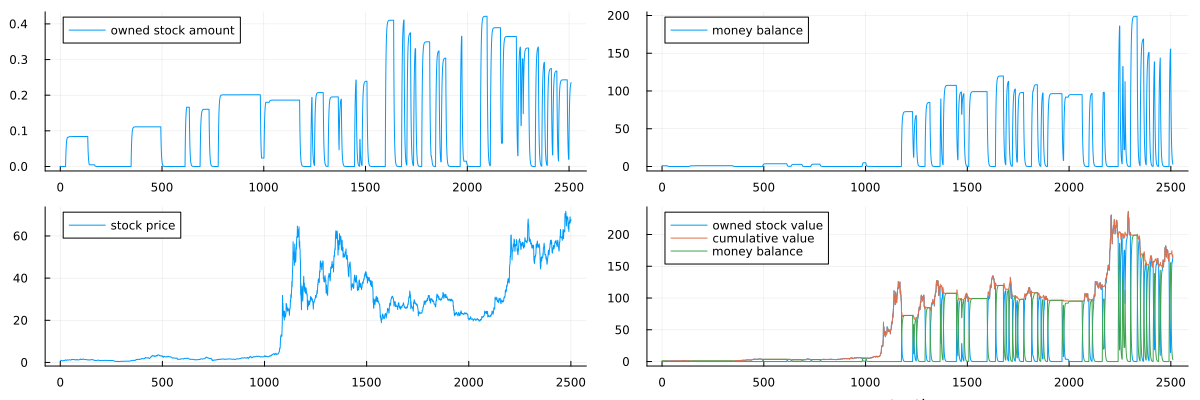

In [120]:
p=plot(snapshots_s, label="owned stock amount", layout=(2,2), size=(1200,400))
plot!(p, snapshots_m, label="money balance", subplot=2)
#plot!(p, smoothed_price, label="stock price", subplot=3)
plot!(p, #= smoothed_ =#price[112:end-9]./#= smoothed_ =#price[112], label="stock price", subplot=3)
plot!(p, stock_value, label="owned stock value", subplot=4)
plot!(p, stock_value+snapshots_m, label="cumulative value", subplot=4)
plot!(p, snapshots_m, label="money balance", subplot=4, legend=:topleft, xlabel="testing")
p

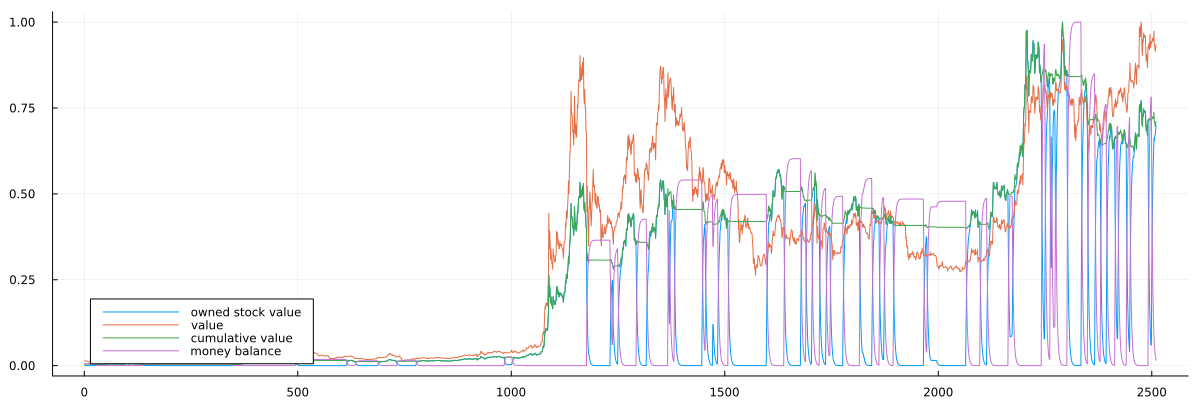

In [121]:
pl=plot(stock_value./maximum(stock_value), label="owned stock value", size=(1200,400), legend=:bottomleft)
plot!(pl,stock_value_decim./maximum(stock_value_decim), label="value")
plot!(pl,(stock_value+snapshots_m)./maximum(stock_value+snapshots_m), label="cumulative value")
plot!(pl,snapshots_m./maximum(snapshots_m), label="money balance")

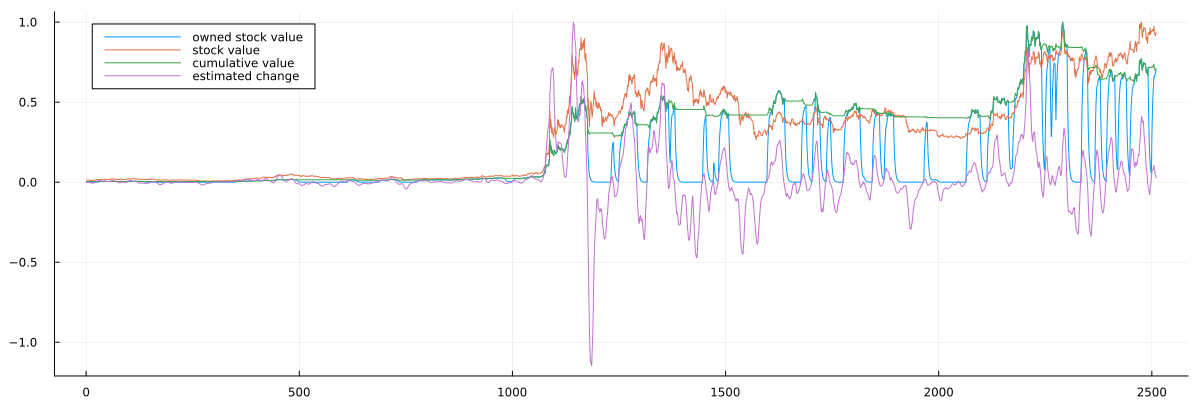

In [122]:
pl=plot(stock_value./maximum(stock_value), label="owned stock value", size=(1200,400))
plot!(pl,stock_value_decim./maximum(stock_value_decim), label="stock value")
plot!(pl,(stock_value+snapshots_m)./maximum(stock_value+snapshots_m), label="cumulative value")
plot!(pl,diffs/maximum(diffs), label="estimated change")
pl

# Count money

In [123]:
returns = 1.0
market_returns = 1.0
returns_h = Vector{Float64}()
market_h = Vector{Float64}()
moneyness = Vector{Vector{Float64}}()
market = Vector{Vector{Float64}}()

market_start = 0.0
market_end = 0.0

algo_start = 0.0
algo_end = 0.0

training_width = 100
prediction_width = 10
timestep = 10

#strategy = "tree_GP"
#strategy = "LS"
strategy = "FS"

names = [#= "Fuji Electric ADR", "Metal Component Engineering Ltd", "Perdoceo Education", "American Airlines", =# "3M", #="Apple",=#  "Coca-Cola", "Exxon Mobil", "Ford Motor", "Intel", #="Microsoft",=# #="NVIDIA", =#"Pfizer"#=, "K", "EA"=#]
for name in names
    if strategy == "tree_GP"
        res, price = load(joinpath(@__DIR__, "evaluations", "tree_GP", name, "predictions.jld2"))["res"];
    elseif  strategy == "LS"
        res, price = load(joinpath(@__DIR__, "evaluations", "LS", name, "predictions.jld2"))["res"];
    elseif  strategy == "FS"
        res, price = load(joinpath(@__DIR__, "evaluations", name, "predictions.jld2"))["res"];
    end

    #my_returns, stock_returns = EO.simulate_trading(res, price, training_width, prediction_width, timestep)

    balance = 1 # unit is money
    stock_balance = 0
    volatility = 0.3          # speed of fund moving, 1 means all cash moves from one asset to the other instantly
    required_certainty = 1
    λ = 0.1

    snapshots_s = Vector{Float64}()
    snapshots_m = Vector{Float64}()
    stock_value = Vector{Float64}()
    stock_value_decim = Vector{Float64}()

    prev_diff = nothing

    i = 1
    for prediction in res
        push!(snapshots_m, balance)
        push!(snapshots_s, stock_balance)

        #update balance
        previous_price = price[(2+timestep*(i-1))]
        current_price = price[(2+prediction_width+training_width+timestep*(i-1))]

        change = current_price/previous_price
        push!(stock_value, stock_balance*current_price)
        push!(stock_value_decim, current_price)

        pr = EO.signal_mean(mean(prediction))
        last_known_val = pr[training_width]
        predicted_val  = pr[training_width+prediction_width]

        diff = 10*(predicted_val - last_known_val)
        if isnothing(prev_diff)
            prev_diff = diff
        else
            diff = (1-λ)*prev_diff + λ*diff
            prev_diff = diff
        end
        if abs(diff) > required_certainty
            if diff < 0         # the value will go down
                #sell
                trade_amount = stock_balance*volatility
                stock_balance = stock_balance - trade_amount

                balance = balance + trade_amount*current_price
                balance -= trade_amount*current_price*0.01
            elseif diff > 0
                #buy
                trade_amount = balance*volatility
                balance = balance - trade_amount
                
                stock_balance = stock_balance + trade_amount/current_price
                balance -= trade_amount*0.01
            end
        end
        i+=1
    end

    my_returns = (stock_value+snapshots_m)[end]/(stock_value+snapshots_m)[1]
    stock_returns = stock_value_decim[end]/stock_value_decim[1]

    push!(returns_h, my_returns)
    push!(market_h, stock_returns)
    push!(moneyness, stock_value+snapshots_m)
    push!(market, stock_value_decim)

    market_start += stock_value_decim[1]
    market_end += stock_value_decim[end]
    algo_start += (stock_value+snapshots_m)[1]
    algo_end += (stock_value+snapshots_m)[end]

    returns += my_returns
    market_returns += stock_returns
end

market_returns = market_end/market_start
returns = algo_end/algo_start

println("I made $(returns) profits")
println("The market made $(market_returns) profits")

println(returns_h)
println(market_h)
println(returns_h |> sum)
println(market_h |> sum)
p = plot(sum(moneyness)./sum(moneyness)[1], label="trading performance")
plot!(sum(market)./sum(market)[1], label="market performance", size=(600, 200))